# Test ellipse fit

## Imports

In [1]:
# Python standard library
import sys
import csv
import os

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [2]:
date = '7-19-2017/'
particle = '293-T/'
channel = '15-30-15_4/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events' + '.json'

In [3]:
# Load video
res_x = 512
res_y = 288
oi_fps = 100000
exposure = 5
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, oi_fps, exposure)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

print 'loaded', len(oi_events), 'oi events'

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


loaded 137 oi events


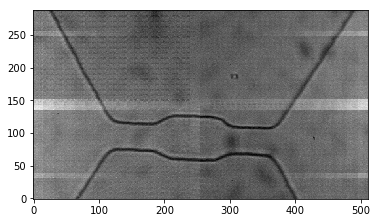

In [4]:
template_index = 1500

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.04431127  0.99901777]


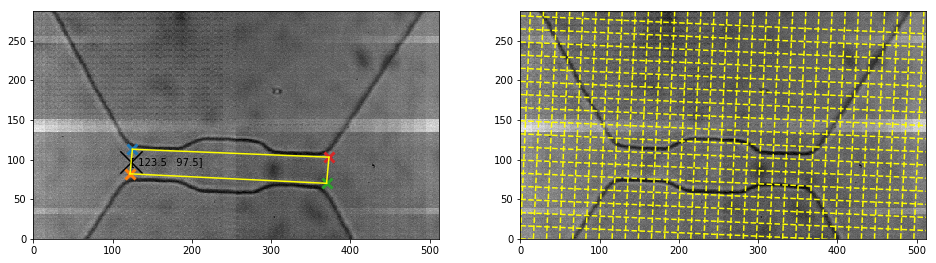

In [5]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [125,113]
c1 = [122,82]
c2 = [370,70]
c3 = [373,103]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Define plotting functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()
    


## Find event to test fit on

In [7]:
oi_index = 14
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf, oi_fps).to_html5_video())

## Define ellipse fitting functions

In [86]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []



        


def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection, debug = 'none'):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
        
        
    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    processed_template_frame = crop_frame(processed_template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)
        
        




    #################################
    # Blur
    #################################


    blur_kernel = (15,15)    # 19
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    
    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)
    processed_template_frame = cv2.GaussianBlur(processed_template_frame, blur_kernel, 0)
    


    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)
    
    

        
        

        
    #################################
    # Processed-template Negative
    #################################



    preprocessing_steps.append(['processed-template negative'])

    processed_frame = processed_template_frame - processed_frame


    if debug == 'all':
        print 'processed-template negative'
        plot_all(processed_frame, frame)
        



    
    
    #################################
    # Inversion
    #################################
    '''
    preprocessing_steps.append(['inversion'])

    processed_frame = 1-processed_frame



    if debug == 'all':
        print 'inversion'
        plot_all(processed_frame, frame)
    '''
    
    

    #################################
    # Gradient
    #################################
    
    preprocessing_steps.append(['gradient'])

    processed_frame = cv2.Laplacian(processed_frame, cv2.CV_64F)



    if debug == 'all':
        print 'gradient'
        plot_all(processed_frame, frame)
    
    
    #################################
    # Inversion
    #################################
    
    preprocessing_steps.append(['inversion'])

    processed_frame = 1-processed_frame



    if debug == 'all':
        print 'inversion'
        plot_all(processed_frame, frame)
    
    
     

    

    #################################
    # Adaptive thresholding
    #################################
    '''
    threshold_ratio = 0.7
    
    threshold = np.max(processed_frame) - (np.max(processed_frame) - np.min(processed_frame))*threshold_ratio
    
    preprocessing_steps.append(['pixel intensity adaptive threshold', threshold_ratio])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)




    if debug == 'all':
        print 'adaptive threshold'
        plot_all(processed_frame, frame)
    '''

    
    #################################
    # Rescale
    #################################
    
    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))

    

    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)
    
    
    
    
    ##################################
    # Static thresholding
    ##################################
    
    '''
    threshold = .555  # .5
    
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)




    if debug == 'all':
        print 'static threshold', threshold
        plot_all(processed_frame, frame)
    '''

    
    
    ##################################
    # Adaptive thresholding histogram derivative
    ##################################
    
    sigma = 3
    
    print 'adaptive thresholding histogram derivative, sigma = ', sigma, 'derivative threshold = half max'
            
    total_bins = 100

    counts, bins = np.histogram(processed_frame, bins = 100)

    
    smoothed_counts = scipy.ndimage.filters.gaussian_filter(counts, sigma = 3)


    derivative_smoothed_counts = np.gradient(smoothed_counts)


    derivative_threshold = np.abs(np.min(derivative_smoothed_counts)/2)

    for i in range(len(derivative_smoothed_counts)):
        if np.abs(derivative_smoothed_counts[-1-i]) > derivative_threshold:
            index = -1-i
            break
            
    threshold = (bins[index] + bins[index-1])/2.

    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)
    
    if debug == 'all':
        print 'adaptive threshold', 'sigma = ', sigma, 'derivative threshold = half max', threshold
        plot_all(processed_frame, frame)
    


    #################################
    # Erode subtraction
    #################################
    '''
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    '''



    
    

    #################################    
    # Get largest cluster
    #################################
    '''
    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)
    '''

    
    
    #################################    
    # Cluster filtering
    #################################
    
    
    cluster_threshold = 100
    preprocessing_steps.append(['cluster filtering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster threshold', cluster_threshold
        plot_all(processed_frame, frame)
    

    
    
    #################################
    # Pad (numpy)
    #################################
    
    
    pad_width = 20
    #processing_steps.append('pad, pad width = ', pad_width)
    
    processed_frame = np.lib.pad(processed_frame, pad_width, 'constant')
    
    
    if debug == 'all':
        #print 'pad, width = ', pad_width
        plot_all(processed_frame, frame)
    
    
    #################################
    # Morphological closing (opencv)
    #################################
    
    morph_kernel_size = (45,45) #15
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)
    
    
    
    #################################
    # Unpad (numpy)
    #################################
    
    processed_frame = processed_frame[pad_width:-pad_width, pad_width:-pad_width]
    
    
    
    
    
    if debug == 'all':
        #print 'rescale'
        plot_all(processed_frame, frame)
     
    
    
    
    #################################
    # Morphological closing (scipy)
    #################################
    '''
    processed_frame = scipy.ndimage.morphology.binary_closing(processed_frame, structure = np.ones((35,35)))
    
    if debug == 'all':
        print 'morphological closing (scipy)'
        plot_all(processed_frame, frame)
    '''


    #################################
    # Erode subtraction
    #################################
    
    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    
        
        
        
        
    
    
        
        
        
    
    #################################
    # Fill holes
    #################################
    
    '''
    preprocessing_steps.append(['fill holes'])

    processed_frame = np.array(scipy.ndimage.binary_fill_holes(processed_frame), dtype = np.uint8)

    print processed_frame.dtype


    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)
    '''  
        
    #################################
    # Dilate subtraction
    #################################
    '''
    iterations = 3
    preprocessing_steps.append(['dilation subtraction, iterations = ', iterations])

    processed_frame = scipy.ndimage.binary_dilation(processed_frame) - processed_frame


    if debug == 'all':
        print 'dilate subtraction'
        plot_all(processed_frame, frame)
    '''
    
    
    
    
        
        
        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = [ellipse_center[0] + detection._px - crop_distance, ellipse_center[1] + detection._py - crop_distance]

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (12,3))
        
        
        # Axes 0
        plt.sca(axes[0])
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        # Axes 2
        plt.sca(axes[2])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
        plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')
        
        plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
        plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')
        
        plt.text(1, 0.2, r'$|a|=$'+str(round(ellipse_axes_lengths[0],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        plt.text(1, 0.1, r'$|b|=$'+str(round(ellipse_axes_lengths[1],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')

        plt.text(1, 0, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.grid()
                
        plt.show()
        
        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]


##### Test fit

copy


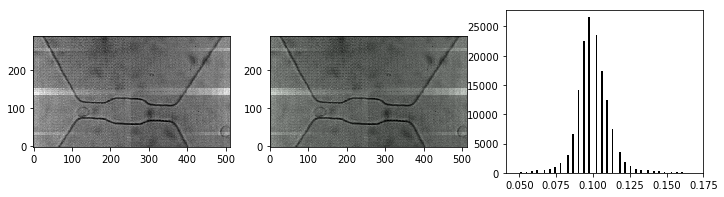

crop


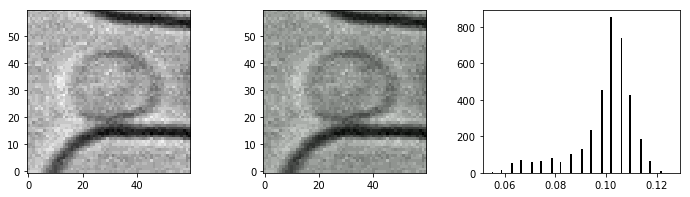

In [ ]:
xs = oi_event.get_px()
ys = oi_event.get_py()

xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)

xcs = oi_stage.pixels_to_meters(xcs)


xc_left = 0
xc_right = 150

for j, detection in enumerate(oi_event._detections):
    try:
        if xcs[j] >= xc_left and xcs[j] <= xc_right:



            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)

            
            # Get ellipse/preprocess the frame
            ellipse = preprocess_fit_ellipse(raw_frame, template_frame, detection, debug = 'all')
            
            print ellipse[0], ellipse[1]
            
    except Exception as e:
        print 'failed on ', j, len(oi_event._detections)
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        pass

##### Test determined ellipse parameters

failed on  0 147
failed on  1 147
failed on  2 147
failed on  3 147
failed on  4 147
failed on  5 147
failed on  6 147
failed on  7 147
failed on  8 147
failed on  9 147
failed on  10 147
failed on  11 147
failed on  12 147
failed on  13 147
failed on  14 147
failed on  15 147
failed on  16 147
failed on  17 147
failed on  18 147
failed on  19 147
failed on  20 147
failed on  21 147
failed on  22 147
failed on  23 147
failed on  24 147
failed on  25 147
failed on  26 147
failed on  27 147
failed on  28 147
failed on  29 147
failed on  30 147
failed on  31 147
10.3008785547 11.7111588921
10.7388077904 12.2509899853
10.5690374318 12.1468493162
10.7565862704 12.2986840833
10.1940264127 12.0847290529
10.4004111489 12.0052482645
10.0392330381 11.5523976045
11.1646057613 12.5966185963
11.3645861283 12.9494523205
11.0145753049 12.4680753403
11.5878845338 12.963656841
11.3290584674 12.7300126407
11.6539839022 12.7318010336
10.6765369478 12.4189020414
12.1264439237 13.0014742558
11.5234656723 1

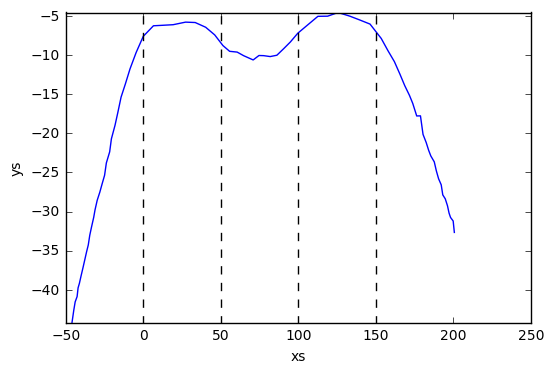

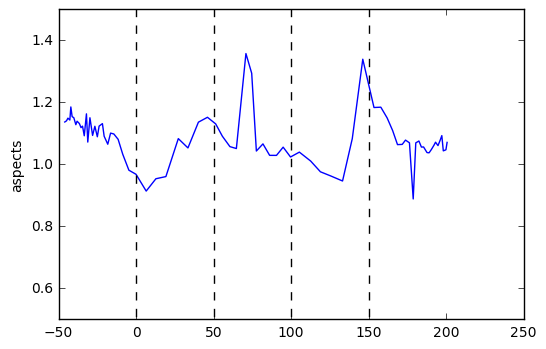

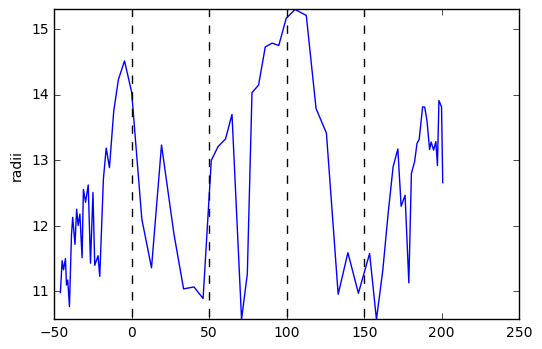

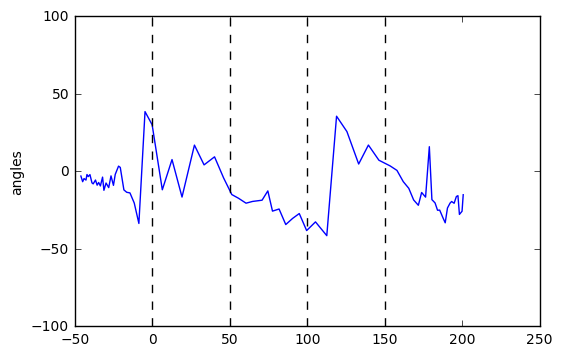

In [47]:
xs = oi_event.get_px()
ys = oi_event.get_py()

xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)

xcs = oi_stage.pixels_to_meters(xcs)


ellipse_xs = []
ellipse_ys = []
ellipse_as = []
ellipse_bs = []
ellipse_aspects = []
ellipse_angles = []
ellipse_radii = []

for j, detection in enumerate(oi_event._detections):
    try:

        # Get raw frame
        raw_frame = oi_vid.get_frame(detection._tf)


        ellipse = preprocess_fit_ellipse(raw_frame, template_frame, detection, debug = 'none')

        # Get ellipse parameters
        x = ellipse[0]
        y = ellipse[1]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        yc = oi_stage.pixels_to_meters(yc)
        
        ellipse_xs.append(xc)
        ellipse_ys.append(yc)

        # Axes
        ellipse_a = ellipse[2]
        ellipse_b = ellipse[3]
        
        ellipse_angle = ellipse[4]
        
        ellipse_a = np.abs(ellipse[2]*np.cos(ellipse_angle)) + np.abs(ellipse[3]*np.sin(ellipse_angle))
        ellipse_b = np.abs(ellipse[2]*np.sin(ellipse_angle)) + np.abs(ellipse[3]*np.cos(ellipse_angle))
        
        
        
        
        ellipse_as.append(ellipse_a)
        ellipse_bs.append(ellipse_b)
        
        
        # Radius
        ellipse_radius = np.sqrt(ellipse_a*ellipse_b)
        print ellipse_a, ellipse_b
        #ellipse_radius = oi_stage.pixels_to_meters(ellipse_radius)
        ellipse_radii.append(ellipse_radius)
        
        # Ellipse aspect
        ellipse_aspects.append(ellipse_b/ellipse_a)

            
        
        # Angle
        ellipse_angles.append(180.*ellipse[4]/np.pi)
        
        
        
            
            
    except:
        print 'failed on ', j, len(oi_event._detections)
        pass
    
    
'''plt.plot(ellipse_xs)
plt.ylabel('xs')
plt.show()



plt.plot(ellipse_ys)
plt.ylabel('ys')
plt.show()
'''
# Trajectory
plt.plot(ellipse_xs, ellipse_ys)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylim(np.min(ellipse_ys), np.max(ellipse_ys))
plt.xlabel('xs')
plt.ylabel('ys')
plt.show()


# Aspects
plt.plot(ellipse_xs, ellipse_aspects)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('aspects')
plt.ylim(0.5,1.5)
plt.show()


# Radii
plt.plot(ellipse_xs, ellipse_radii)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('radii')
plt.ylim(np.min(ellipse_radii), np.max(ellipse_radii))
plt.show()


# Angles
plt.plot(ellipse_xs, ellipse_angles)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('angles')
plt.show()